In [2]:
# --------------------------------------------------------------------------- #
# Sardhendu Mishra
# Note: The ipython Spark Shell automatically instantiate a SparkContext and HiveContext, 
#       there's one created automatically called sqlContext
#       No need to do sc = SparkComtext('local', 'name') and sqlContext = SQLContext(sc)

# --------------------------------------------------------------------------- #


# All imports Done Here
from __future__ import print_function
from IPython.display import display

# Spark API's
from pyspark import SparkContext
from pyspark.mllib.stat import Statistics
from pyspark.sql import SQLContext
from pyspark.sql import functions as func
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from toolz.functoolz import curry   # To send multiple arguments to spark tranformations such as map, flatMap, reduce and others

# Imports of MLLIB
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors, Matrices
from pyspark.ml.regression import GeneralizedLinearRegression

# Other API's
import math
import plotly.plotly as py
from plotly.graph_objs import *
import pandas as pd
import requests
import csv
import numpy as np
import random
from itertools import chain
from collections import OrderedDict


dataDir = "/Users/sam/All-Program/App-DataSet/Spark-Operations/diabetes_dataset/diabetic_data.csv"
dataModel1 = '/Users/sam/All-Program/App-DataSet/Spark-Operations/diabetes_dataset/daibetic_dataModel1.csv'
dataModel2 = '/Users/sam/All-Program/App-DataSet/Spark-Operations/diabetes_dataset/daibetic_dataModel2.csv'

trainSampleModel1 = '/Users/sam/All-Program/App-DataSet/Spark-Operations/diabetes_dataset/trainSampleModel1.csv'
testSampleModel1 = '/Users/sam/All-Program/App-DataSet/Spark-Operations/diabetes_dataset/testSampleModel1.csv'
validSampleModel1 = '/Users/sam/All-Program/App-DataSet/Spark-Operations/diabetes_dataset/validSampleModel1.csv'

In [3]:
# Feature Description
featureSchema = OrderedDict()
featureSchema['encounter_id'] = 'int'                 # Unique identier of an encounter
featureSchema['patient_nbr'] = 'int'                  # Unique identier of a patient
featureSchema['race'] = 'string'                      # Values: Caucasian, Asian, African American, Hispanic, and other
featureSchema['gender'] = 'string'                    # Values: male, female, and unknown/invalid
featureSchema['age'] = 'string'                       # Grouped in 10-year intervals: [0, 10), [10, 20), . . ., [90, 100)
featureSchema['weight'] = 'string'                    # Weight in range
featureSchema['admission_type_id'] = 'string'         # Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available         
featureSchema['discharge_disposition_id'] = 'string'  # Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available          
featureSchema['admission_source_id'] = 'string'       # Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital
featureSchema['time_in_hospital'] = 'int'             # Integer number of days between admission and discharge
featureSchema['payer_code'] = 'string'                # Integer identifier corresponding to 23 distinct values, for example, Blue Cross\Blue Shield, Medicare, and self-pay    
featureSchema['medical_specialty'] = 'string'         # Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family\general practice, and surgeon
featureSchema['num_lab_procedures'] = 'int'           # Number of lab tests performed during the encounter                  
featureSchema['num_procedures'] = 'int'               # Number of procedures (other than lab tests) performed during the encounter     
featureSchema['num_medications'] = 'int'              # Number of distinct generic names administered during the encounter           
featureSchema['number_outpatient'] = 'int'            # Number of outpatient visits of the patient in the year preceding the encounter
featureSchema['number_emergency'] = 'int'             # Number of emergency visits of the patient in the year preceding the encounter
featureSchema['number_inpatient'] = 'int'             # Number of inpatient visits of the patient in the year preceding the encounter
featureSchema['diag_1'] = 'string'                    # The primary diagnosis (coded as  rst three digits of ICD9); 848 distinct values
featureSchema['diag_2'] = 'string'                    # Secondary diagnosis (coded as  rst three digits of ICD9); 923 distinct values
featureSchema['diag_3'] = 'string'                    # Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values
featureSchema['number_diagnoses'] = 'int'             # Number of diagnoses entered to the system
featureSchema['max_glu_serum'] = 'string'             # Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured
featureSchema['A1Cresult'] = 'string'                 # Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured.

# Other medication features (Nominal)
featureSchema['metformin'] = 'string'
featureSchema['repaglinide'] = 'string' 
featureSchema['nateglinide'] = 'string'
featureSchema['chlorpropamide'] = 'string'
featureSchema['glimepiride'] = 'string' 
featureSchema['acetohexamide'] = 'string' 
featureSchema['glipizide'] = 'string'
featureSchema['glyburide'] = 'string'
featureSchema['tolbutamide'] = 'string'
featureSchema['pioglitazone'] = 'string'
featureSchema['rosiglitazone'] = 'string'
featureSchema['acarbose'] = 'string'
featureSchema['miglitol'] = 'string'
featureSchema['troglitazone'] = 'string'
featureSchema['tolazamide'] = 'string'
featureSchema['examide'] = 'string'
featureSchema['citoglipton'] = 'string'
featureSchema['insulin'] = 'string'
featureSchema['glyburide_metformin'] = 'string' 
featureSchema['glipizide_metformin'] = 'string'
featureSchema['glimepiride_pioglitazone'] = 'string'
featureSchema['metformin_rosiglitazone'] = 'string'
featureSchema['metformin_pioglitazone'] = 'string'

# Other Features
featureSchema['change'] = 'string'                    # Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”
featureSchema['diabetesMed'] = 'string'               # Indicates if there was any diabetic medication prescribed. Values: “yes” and “no”


# The Class Variable
featureSchema['readmitted'] = 'string'                # '<30'-> if the patient was readmitted in 30 days), '>30'-> readmit in more than 30days, 'No'-> no record on readmission

featuresList = featureSchema.keys()
# len(featuresList)


# Data Loading and Instance based Data Cleaning:

1. Load the data from the csv file into a dataFrame.
2. Clean Instances. Keep only one encounter per patient. Keep only the first encounter of the patient in the hospital and remove all the instances corresponding to other than the first encounter per patient.
3. Convert the dependent variable into two class 1)readmitted=yes and 2)readmitted=no.
4. Perform Sanity Check of the clean Data Frame


In [3]:
def cleanNull(value):        
    if value == '?':# or value == None or value == 'None':
        return np.NaN
    else: return value

In [4]:
############################################
# 1. Load the data from the csv file into a dataFrame.
############################################

diabeticDF = sqlContext.read.load(dataDir, 
                      format='com.databricks.spark.csv', 
                      header='true', 
                      inferSchema='true')

# diabeticDF = diabeticDF.select(*featuresList)
# # len(diabeticDF.toPandas().columns)

# Clean the data of '?' and check for if data types are infered correctly by the sqlContext
for featureName, dtype in featureSchema.items():
    if dtype == 'int':
        udfCleanNull = func.udf(cleanNull, IntegerType())
        diabeticDF = diabeticDF.withColumn(featureName, udfCleanNull(featureName))
    elif dtype == 'string':
        udfCleanNull = func.udf(cleanNull, StringType())
        diabeticDF = diabeticDF.withColumn(featureName, udfCleanNull(featureName))
    else:
        pass
    
diabeticDF.registerTempTable('diabeticTable')       
diabeticDF.toPandas().head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
###############################################################
# 2. Clean Instances. Keep only one encounter per patient. Here we keep only the first encounter of the patient in the hospital and remove all other instances.
###############################################################

# Since we are intersted in knowing, if a patient will revisit the hospital in <30 days, >30 days. 
# We will have to clean the data of the following.
    # 1. There are multiple encounterID of several patients
    # 2. If the patients have expired: They will never be readmitted
    # 3. If a patient has been sent to a hospice: Negligible chance of readmission, doctor's might visit them not the other way round



# Find all patients will multiple encounterID
print ('Top three patients with multiple encounterID ...........................................')
diabeticDF.groupBy('patient_nbr').count().orderBy('count',ascending=False).show(3)
# print ('')


# Check the distribution of the label (readmitted) given a patient with multiple encounter_id
print ('Readmission data for patients with multiple encounterID ................................')
diabeticDF.select('encounter_id', 'readmitted').where(diabeticDF['patient_nbr'] == '88785891').show(3)


# Fetch the first encounter_id per patient. One patient may have many encounter_id's so we just use the min(first) encounter id for our model. 
# Other way of saying it is that per patient we would wanna have only the first encounter  
unqEncounterIDs = diabeticDF.groupBy('patient_nbr').agg(func.min('encounter_id').alias('encounter_id'))
# print (unqEncounterID.count())
print ('Number of First encounter per person is : ', unqEncounterIDs.count())
print ('')



#------------------------------------------------------------------------------#



# Check the distribution of the "readmitted" column of expired patients: Should be 1 because expired patients wouldnt be readmitted
# 11-> Expired, 19-> Expired at home, 20-> Expired at medicl center, 21-> Expired place unknown
print ('Readmission data for expired patients ..................................................')
expiredIDs = [11, 19, 20, 21]

# Find the encounter_id, patients_id of patients who have already expired
expPatientIDs = diabeticDF.select('patient_nbr', 'encounter_id').where(diabeticDF['discharge_disposition_id'].isin(expiredIDs))
print ('Number of encounter per expired person is : ', expPatientIDs.count())

expPatientIDs.show(3) # Top 3 Expired Patients
expPatientIDs.groupBy('patient_nbr').count().orderBy('count', ascending=False).show(5)

# Fetch all the encounter_id for expired patients.
# expPatientIDs = expPatientIDs['encounter_id']
# 
print ('')



#------------------------------------------------------------------------------#


# Check the distribution of the "readmitted" column of hospiced patients: See if any patient was readmitted
# 13 -> Hospice to home, 14 -> Hospice to medical facility
print ('Readmission data for hospiced patients .................................................')
hospiceIDs = [13, 14]
# Find the encounter_id, patients_id of patients who have already expired
hosPatientIDs = diabeticDF.select('patient_nbr', 'encounter_id').where(diabeticDF['discharge_disposition_id'].isin(hospiceIDs))
print ('Number of encounter per person send to hospice is : ', hosPatientIDs.count())

hosPatientIDs.show(3) # Top 3 Expired Patients
hosPatientIDs.groupBy('patient_nbr').count().orderBy('count', ascending=False).show(5)
# Check the readmission column for any one of the hospicedpatient that has mltiple encounterIds one of the parie
diabeticDF.select('encounter_id', 'readmitted').where(diabeticDF['patient_nbr'] == '72109872').show(3)

# Fetch the first encounter_id per patient send to hospice.
# hosPatientIDs = hosPatientIDs['encounter_id']
print ('')


#------------------------------------------------------------------------------#


# Find the encounter ID's after eliminating all the above instances,
# then select from diabeticDF records with those encounterIDs
diabeticCleanDF = (diabeticDF
                   .join(unqEncounterIDs
                         .join(expPatientIDs, 'encounter_id', "leftanti")   # remove expired patients records
                         .join(hosPatientIDs, 'encounter_id', 'leftanti')   # remove hospiced patient records
                         .select('encounter_id'),                           # select only the 'encounter_id' column form the new dataframe
                         'encounter_id',                                    # Join with 'encounter_id' of the diabeticDF
                         'inner'                                            # Perform a inner join
                        )
                   )

diabeticCleanDF.cache()

Top three patients with multiple encounterID ...........................................
+-----------+-----+
|patient_nbr|count|
+-----------+-----+
|   88785891|   40|
|   43140906|   28|
|   88227540|   23|
+-----------+-----+
only showing top 3 rows

Readmission data for patients with multiple encounterID ................................
+------------+----------+
|encounter_id|readmitted|
+------------+----------+
|   119039172|       >30|
|   125094312|       <30|
|   126171582|       >30|
+------------+----------+
only showing top 3 rows

Number of First encounter per person is :  71518

Readmission data for expired patients ..................................................
Number of encounter per expired person is :  1652
+-----------+------------+
|patient_nbr|encounter_id|
+-----------+------------+
|    3327282|      293118|
|   80177094|      450210|
|  110537262|      712350|
+-----------+------------+
only showing top 3 rows

+-----------+-----+
|patient_nbr|count|
+------

DataFrame[encounter_id: int, patient_nbr: int, race: string, gender: string, age: string, weight: string, admission_type_id: string, discharge_disposition_id: string, admission_source_id: string, time_in_hospital: int, payer_code: string, medical_specialty: string, num_lab_procedures: int, num_procedures: int, num_medications: int, number_outpatient: int, number_emergency: int, number_inpatient: int, diag_1: string, diag_2: string, diag_3: string, number_diagnoses: int, max_glu_serum: string, A1Cresult: string, metformin: string, repaglinide: string, nateglinide: string, chlorpropamide: string, glimepiride: string, acetohexamide: string, glipizide: string, glyburide: string, tolbutamide: string, pioglitazone: string, rosiglitazone: string, acarbose: string, miglitol: string, troglitazone: string, tolazamide: string, examide: string, citoglipton: string, insulin: string, glyburide_metformin: string, glipizide_metformin: string, glimepiride_pioglitazone: string, metformin_rosiglitazone: 

In [7]:
###############################################################
# 3. Convert the dependent variable into two class 1) readmitted=yes, 2) readmitted=no
###############################################################

# The class label has three categories 1)readmitted in <30 days, 2)readmitted in >30 days and 3)NO (no record found) which means the patient was not readmitted.
# Here we converet the problem into a two class problem i.e 1) readmitted =yes if <30 days or >30 days. else: 2) readmitted = no

def convrtClass(value):
    if value=='<30' or value=='>30':
        return 'yes'
    else:
        return 'no'
    
    
udfconvrtClass = func.udf(convrtClass, StringType())
diabeticCleanDF = diabeticCleanDF.withColumn('readmitted', udfconvrtClass('readmitted'))

In [8]:
###############################################################
# 4. Perform Sanity Check of the clean table
###############################################################

# 1. Check multiple occurance of patient id, 
# 2. Check, only one patient_nbr should map to one encounter_id
# 3. Check if the dependent variable now has only two classes

numInstances = diabeticCleanDF.count()
unqPatientNBR = diabeticCleanDF.groupBy('patient_nbr').count().agg(func.count('count')).collect()
diabeticCleanDF.groupBy('readmitted').count().show()

print ('Total number of Instances after cleanining: ', numInstances)
print ('Total number of unique Patient NBR: ', unqPatientNBR)

+----------+-----+
|readmitted|count|
+----------+-----+
|        no|41474|
|       yes|28499|
+----------+-----+

Total number of Instances after cleanining:  69973
Total number of unique Patient NBR:  [Row(count(count)=69973)]



# Nominal Features: Preliminary analysis

1. Get the Nominal Features.
2. Group by all Nominal features. See if the categories are roughly distributed uniformly.
3. Group by all Nominal features given the Class label. Check if the categories are equally distributed given Class label category.
4. Check if the Nominal features explains variation in the labels using Chi-square statistics. Measure the significance using p-value.
5. Check the summary and relationship statistics of the Nominal Features.


In [9]:
#############################################
# 1. Get the Nominal Features
#############################################

diabeticCleanDF.printSchema()
nominalFeature = [feature.name for feature in diabeticCleanDF.schema.fields if str(feature.dataType)=='StringType']
print ('Nominal Features are: ', nominalFeature)

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: string (nullable = true)
 |-- discharge_disposition_id: string (nullable = true)
 |-- admission_source_id: string (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- m

In [10]:
###############################################################
# 2. Group by all Nominal features. See if the categories are roughly distributed uniformly.
# 3. Group by all Nominal features given the Class label. Check if the categories are equally distributed given Class label category.
# 4. Check if the Nominal features explains variation in the labels using Chi-square statistics. Measure the significance using p-value.
###############################################################

def chiSquare_stats(feature, labelFeature):
#     print ('')
#     print ('****************************************************************************************')
#     print ('Feature Category is %s ###############################'%feature) 
#     distinctCat = diabeticDF.groupBy(feature).count()
#     distinctCat.show()

    distinctFeatLab = diabeticCleanDF.crosstab(feature, labelFeature).fillna(0)
#     distinctFeatLab.show()

    # The Spark Chi-square library takes in a dense vector in the "value" parameter. 
    # So we first convert the datframe into a dense vector with flattened rows and columns
    # A dataframe is first converted into a matrix of [4x5] and then the matrix is converted into dennse vector of [1x20]
    chi = Statistics.chiSqTest(Matrices.dense(
        numRows=distinctFeatLab.count(), 
        numCols=len(distinctFeatLab.columns) - 1, 
        values=list(chain(*zip(*distinctFeatLab.drop(distinctFeatLab.columns[0]).collect())))   # Convert the contigency metrix into dense vector
    ))

#     print (chi)
#   print ('')
    return chi



In [11]:
###############################################################
# 5. Check the summary statistics of the Nominal Features.
###############################################################

def statNominalfeatures(dataFrameIN):
    numInstances = dataFrameIN.count()
    statNominal = pd.DataFrame(index=['total','numUnqCat','catDistPrcntg','chi_pValue','NaNs','% NaNs'], columns=nominalFeature)
    
    for feature in nominalFeature:
        if featureSchema[feature] != 'string':
            print ('Please provide nominal attributes')
            break

        num_NaNs = dataFrameIN.select(feature).where(func.col(feature)=='NaN').count()
        numCat = dataFrameIN.select(feature).distinct().count()

        if numCat < 10:
            cat_prcntg = (dataFrameIN
                 .groupBy(feature)
                 .count()
                 .select(func.bround((col('count')*100)/numInstances, 2)      # bround is used to round the output
                        .alias('cat_prcntg'))
                 .rdd
                 .map(lambda l: l[0])
                 .collect())
            
        # Chi-Square
        chi_ = chiSquare_stats(feature, 'readmitted')
        statNominal.loc['total',feature] = numInstances
        statNominal.loc['numUnqCat',feature] = numCat
        statNominal.loc['catDistPrcntg',feature] = cat_prcntg
        statNominal.loc['chi_pValue',feature] = chi_.pValue
        statNominal.loc['NaNs',feature] = num_NaNs
        statNominal.loc['% NaNs',feature] = (num_NaNs*100)/numInstances
        
    return statNominal
    
statsNominal = statNominalfeatures(diabeticCleanDF)

with pd.option_context('display.max_columns', None):
    display(statsNominal)
# We see that weight, medical speciality, and payer code are very sparse

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
total,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973
numUnqCat,6,3,10,10,8,21,17,18,71,695,724,757,4,4,4,4,4,4,4,2,4,4,2,4,4,3,4,2,2,1,1,4,4,2,1,2,2,2,2,2
catDistPrcntg,"[74.73, 1.64, 18.04, 2.74, 2.14, 0.7]","[53.2, 0.0, 46.79]","[53.2, 0.0, 46.79]","[53.2, 0.0, 46.79]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[95.22, 1.02, 2.43, 1.34]","[81.64, 8.92, 5.35, 4.09]","[19.48, 1.19, 78.7, 0.62]","[1.17, 0.1, 98.69, 0.04]","[0.67, 0.02, 99.3, 0.01]","[0.09, 0.01, 99.9, 0.0]","[4.76, 0.33, 94.72, 0.19]","[0.0, 100.0]","[11.52, 0.82, 87.13, 0.53]","[9.64, 0.88, 88.89, 0.6]","[0.02, 99.98]","[7.15, 0.25, 92.48, 0.12]","[6.37, 0.19, 93.34, 0.11]","[0.27, 0.01, 99.71]","[0.03, 0.0, 99.97, 0.0]","[0.0, 100.0]","[0.04, 99.96]",[100.0],[100.0],"[30.89, 9.69, 48.96, 10.46]","[0.69, 0.01, 99.29, 0.01]","[0.01, 99.99]",[100.0],"[0.0, 100.0]","[0.0, 100.0]","[45.0, 55.0]","[23.84, 76.16]","[59.27, 40.73]"
chi_pValue,0,3.76485e-05,0,0,0,0,0,0,0,0,0,0,3.13236e-08,1.83268e-09,8.08584e-09,7.07511e-07,0.460575,0.43816,0.474644,0.227679,4.167e-12,0.0550283,0.648318,3.40149e-05,3.88905e-08,0.0104674,0.11114,0.360507,0.409609,1,1,0,0.404903,0.376731,1,0.241067,0.407131,0,0,0
NaNs,1918,0,0,67185,0,0,0,30415,33639,10,293,1224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
% NaNs,2.74106,0,0,96.0156,0,0,0,43.4668,48.0743,0.0142912,0.418733,1.74925,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



# Nominal Features: Vizualizing Relevant Features

1. Bar Plots of the distribution of the label column 'readmitted' for all the missing values (NaNs) of feature 'race'
2. Bar Plots of the distribution of the label column 'readmitted' for all the missing values (NaNs) of feature 'diag_1', 'diag_2', 'diag_3'
3. Bar Plots of the distribution of the label column 'readmitted' for all the categorical values of feature 'A1Cresult'
4. Bar Plots of the distribution of the label column 'readmitted' for all the categorical values of feature 'change'
5. Bar Plots of the distribution of the label column 'readmitted' for all the categorical values of feature 'diabetesMed'


In [12]:
# Common Funcions for vizualization

import matplotlib.pyplot as plt
import matplotlib
from pandas.tools.plotting import scatter_matrix
matplotlib.style.use('ggplot')
%matplotlib inline
            

def vizualize(dataFrameArray, rows, columns, figsize=(40,20), xlabels=None, ylabels=None, titles=None, plot='hist'):
    fig1, axs = plt.subplots(rows,columns, figsize=figsize, facecolor='w', edgecolor='k')   # 
    axs = axs.ravel()
    for num, dataFrame in enumerate(dataFrameArray):
        if plot=='hist':
            dataFrame.plot.hist(ax=axs[num], fontsize = 15)
        elif plot=='box':
            dataFrame.plot.box(vert=True, ax=axs[num], fontsize = 15)
        elif plot=='bar':
            dataFrame.plot.bar(x=xlabels[num], y=ylabels[num], ax=axs[num], fontsize=15)
#             sns.barplot(x=xlabels[num], y=ylabels[num], ax=axs[num], data=dataFrame, palette="Greens_d");
            
#         if xlabels is not None:
#             axs[num].set_xlabel(xlabels[num])
            
        if titles is not None:
            axs[num].set_title(titles[num])
            
            

+----------+-----+
|readmitted|count|
+----------+-----+
|        no|41474|
|       yes|28499|
+----------+-----+



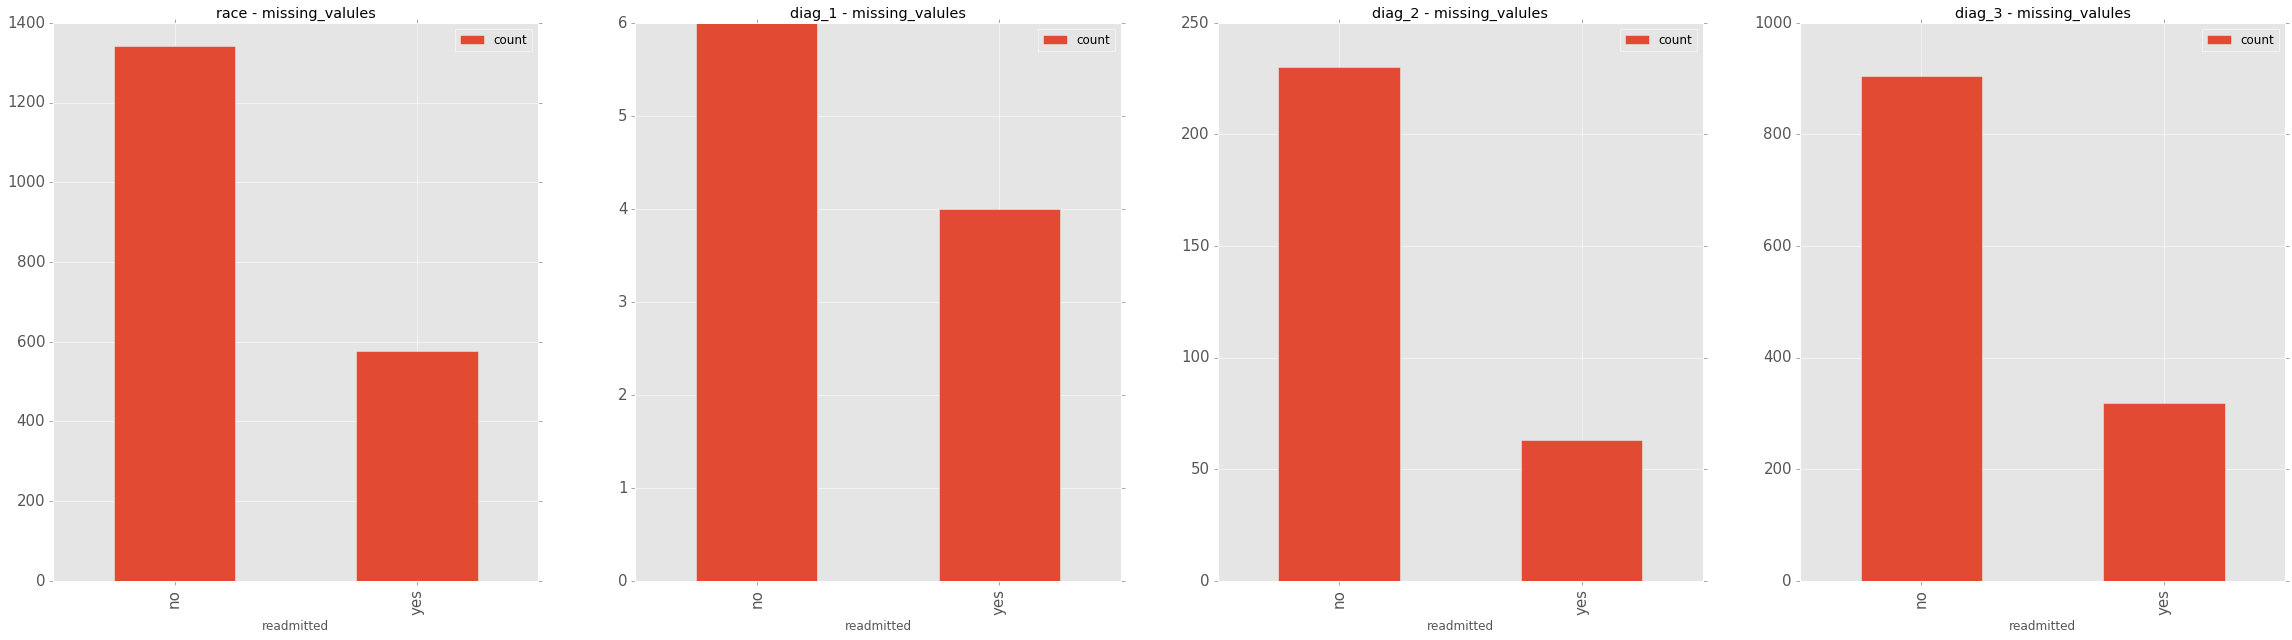

In [13]:
###############################################################
# 1. Bar Plots of the distribution of the label column 'readmitted' 
#   for all the missing values (NaNs) of feature 'race'
# 2. Bar Plots of the distribution of the label column 'readmitted' 
#   for all the missing values (NaNs) of feature 'diag_1', 'diag_2', 'diag_3'
###############################################################

# Lets us look at teh distribution of the labels and other columns for the missing values

diabeticCleanDF.groupBy('readmitted').count().show()
df1 = diabeticCleanDF.select('readmitted').where(func.col('race') == 'NaN').groupBy('readmitted').count().toPandas()
df2 = diabeticCleanDF.select('readmitted').where(func.col('diag_1') == 'NaN').groupBy('readmitted').count().toPandas()
df3 = diabeticCleanDF.select('readmitted').where(func.col('diag_2') == 'NaN').groupBy('readmitted').count().toPandas()
df4 = diabeticCleanDF.select('readmitted').where(func.col('diag_3') == 'NaN').groupBy('readmitted').count().toPandas()

# df1.head()
# # medical_specialty
vizualize([df1,df2,df3,df4], rows=1, columns=4, figsize=(40, 10), 
          xlabels=['readmitted','readmitted','readmitted','readmitted'],
          ylabels=['count','count','count','count'],
          titles=['race - missing_valules','diag_1 - missing_valules','diag_2 - missing_valules','diag_3 - missing_valules'], 
          plot='bar')

+---------+-----+
|A1Cresult|count|
+---------+-----+
|     None|57128|
|       >8| 6239|
|     Norm| 3741|
|       >7| 2865|
+---------+-----+



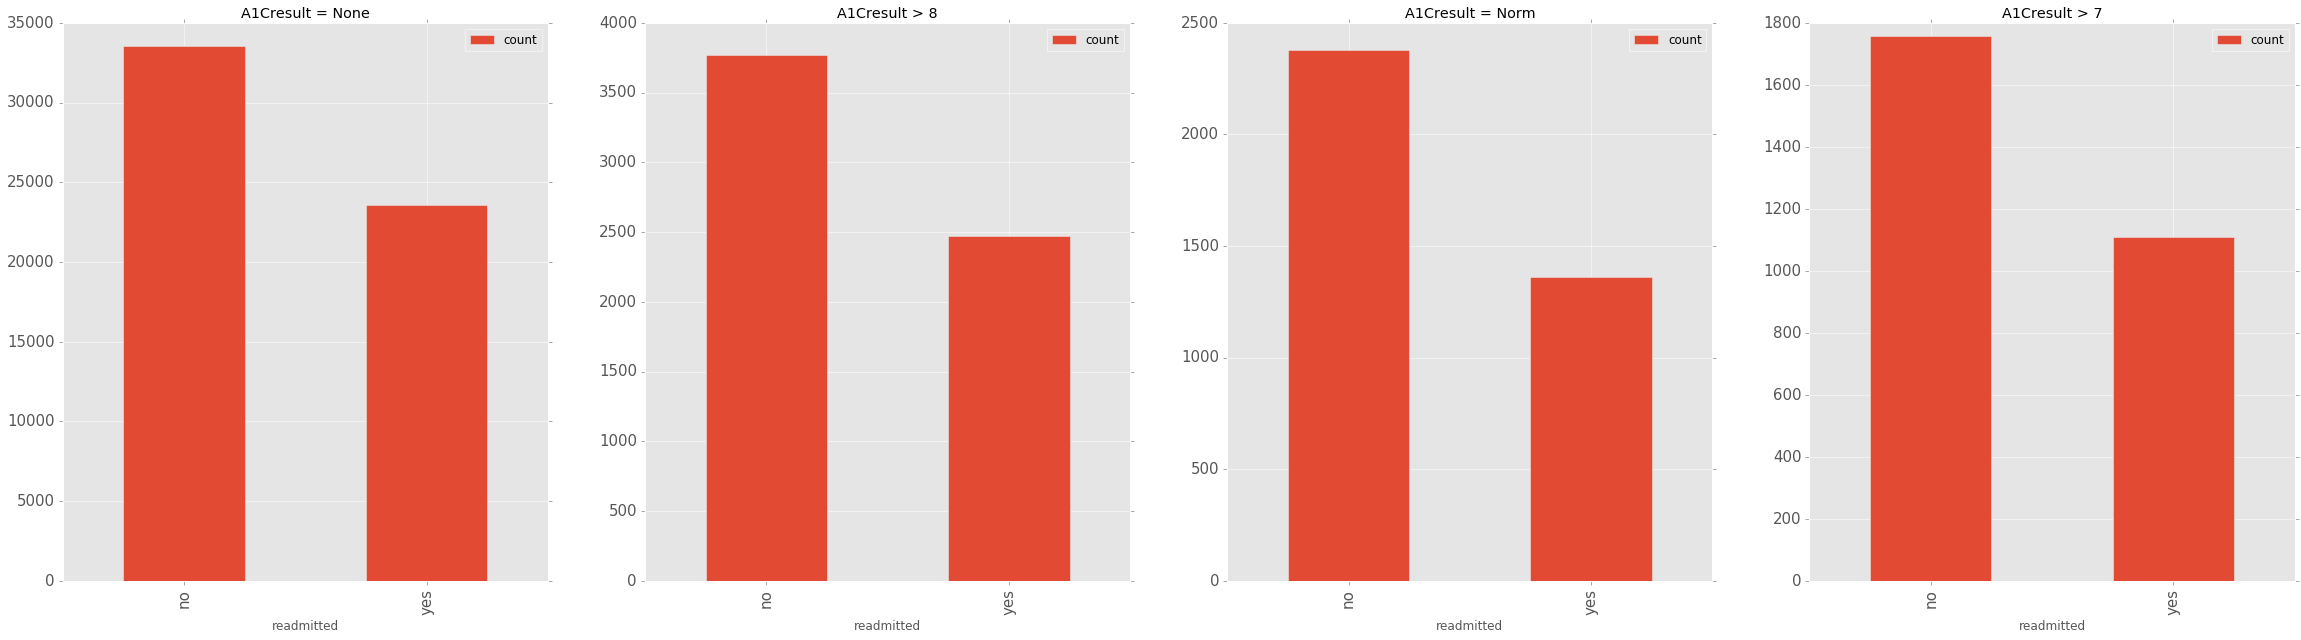

In [14]:
###############################################################
# 3. Bar Plots of the distribution of the label column 'readmitted' 
#    for all the categorical values of feature 'A1Cresult'
###############################################################

diabeticCleanDF.groupBy('A1Cresult').count().show()  # --> None, >8, Norm, >7

A1C_none = diabeticCleanDF.select('readmitted').where(func.col('A1Cresult') == 'None').groupBy('readmitted').count().toPandas()
A1C_g8 = diabeticCleanDF.select('readmitted').where(func.col('A1Cresult') == '>8').groupBy('readmitted').count().toPandas()
A1C_norm = diabeticCleanDF.select('readmitted').where(func.col('A1Cresult') == 'Norm').groupBy('readmitted').count().toPandas()
A1C_g7 = diabeticCleanDF.select('readmitted').where(func.col('A1Cresult') == '>7').groupBy('readmitted').count().toPandas()

title_arr=['A1Cresult = None','A1Cresult > 8','A1Cresult = Norm','A1Cresult > 7']
vizualize([A1C_none,A1C_g8,A1C_norm,A1C_g7], rows=1, columns=4, figsize=(40, 10), 
          xlabels=['readmitted','readmitted','readmitted','readmitted'], 
          ylabels=['count','count','count','count'],
          titles=title_arr, 
          plot='bar')

+------+-----+
|change|count|
+------+-----+
|    Ch|31491|
|    No|38482|
+------+-----+

+-----------+-----+
|diabetesMed|count|
+-----------+-----+
|         No|16680|
|        Yes|53293|
+-----------+-----+



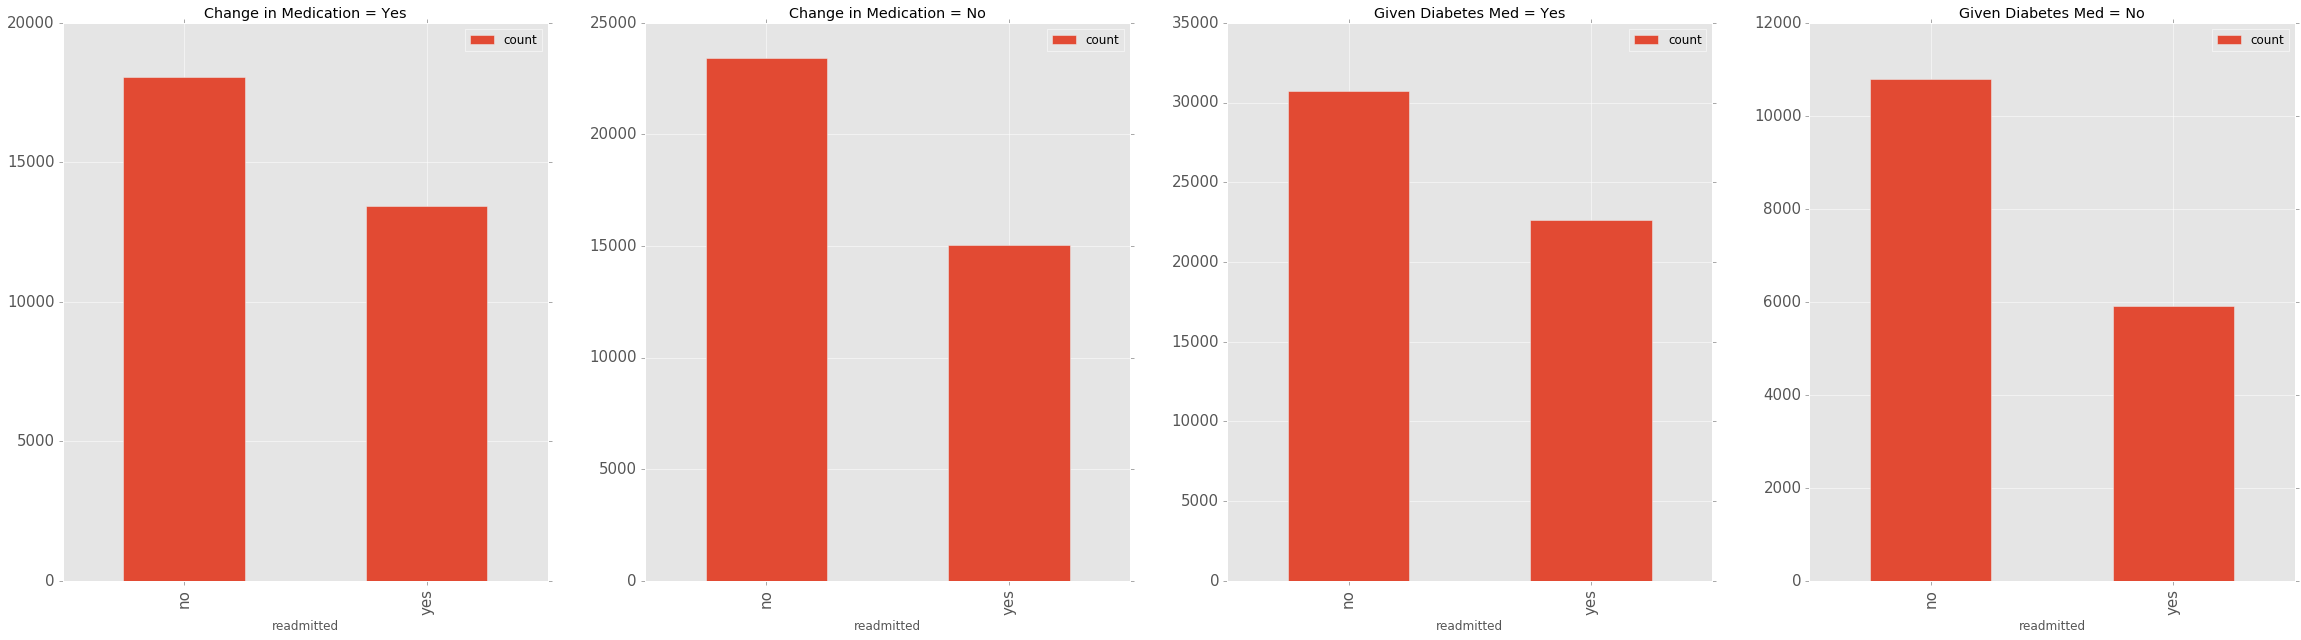

In [15]:
###############################################################
# 4. Bar Plots of the distribution of the label column 'readmitted' 
#    for all the categorical values of feature 'change'
# 5. Bar Plots of the distribution of the label column 'readmitted' 
#    for all the categorical values of feature 'diabetesMed'
###############################################################

# Lets us look at teh distribution of the labels and other columns for the missing values

diabeticCleanDF.groupBy('change').count().show()
diabeticCleanDF.groupBy('diabetesMed').count().show()

change_ch = diabeticCleanDF.select('readmitted').where(func.col('change') == 'Ch').groupBy('readmitted').count().toPandas()
change_no = diabeticCleanDF.select('readmitted').where(func.col('change') == 'No').groupBy('readmitted').count().toPandas()

diabetesMed_yes = diabeticCleanDF.select('readmitted').where(func.col('diabetesMed') == 'Yes').groupBy('readmitted').count().toPandas()
diabetesMed_no = diabeticCleanDF.select('readmitted').where(func.col('diabetesMed') == 'No').groupBy('readmitted').count().toPandas()


title_arr=['Change in Medication = Yes','Change in Medication = No','Given Diabetes Med = Yes','Given Diabetes Med = No']
vizualize([change_ch,change_no,diabetesMed_yes,diabetesMed_no], rows=1, columns=4, figsize=(40, 10), 
          xlabels=['readmitted','readmitted','readmitted','readmitted'], 
          ylabels=['count','count','count','count'],
          titles=title_arr, 
          plot='bar')


# Nominal Features: Data Cleaning and Data Preparation


1. Using the above Statistics for Nominal Features remove non-important Features.
2. Update the List of Nominal Feature.
3. Impute Missing values with proper category. If the distribution is roughly equal, consider imputing it with a new category 'missing'. 
   If the number of missing value for a column is very less then it is a good idea to remove the instances with missing values.
4. Sanity Check : Summary statistics for Nominal Features after removing/replacing all the NaN.



In [16]:
###############################################################
# 1. Using the above Statistics for Nominal Features remove non-important Features.
###############################################################

    
# Drop the columns: and REASON of drop:
# 1. Weight --> Sparse
# 2. Payer Code --> Sparse
# 3. ['acetohexamide', 'tolbutamide', 'troglitazone', 'examide', 'citoglipton', 'glipizide_metformin', 
#     'glimepiride_pioglitazone', 'metformin_rosiglitazone', 'metformin_pioglitazone',
#     'nateglinide', 'glyburide_metformin','chlorpropamide', 'miglitol', 'tolazamide']
#     --> 99% intance distribution for 1 category, chi-square (p_val)>0.1

# See the statistics for the following column and decide if they are relevant or not.



# 100 of the data belongs to only one category:
# statsNominal.loc[:,['acetohexamide', 'troglitazone', 'examide', 'citoglipton', 'glimepiride_pioglitazone', 'metformin_rosiglitazone', 'metformin_pioglitazone']]

# statsNominal.loc[:,['acetohexamide', 'tolbutamide', , 'glipizide_metformin']]

# statsNominal.loc[:,['chlorpropamide', 'miglitol', 'tolazamide']]

# statsNominal.loc[:,['nateglinide', 'acarbose', 'glyburide_metformin']]

# statsNominal.loc[:,['repaglinide']]

# statsNominal.loc[:,['metformin','repaglinide','glimepiride','glipizide','glyburide','pioglitazone','rosiglitazone','acarbose']]

# badNominalFeature1 = (['acetohexamide', 'troglitazone', 'examide', 'citoglipton', 'glimepiride_pioglitazone', 'metformin_rosiglitazone', 'metformin_pioglitazone'])

# badNominalFeatures2 = (['weight','payer_code',  # Sparse
#                        'tolbutamide', 'troglitazone', 
#                        'glipizide_metformin','nateglinide', 
#                        'glyburide_metformin', 'chlorpropamide', 'miglitol', 'tolazamide'])

# def featureSelection():
# diabeticCleanDF_m1 = diabeticCleanDF.drop(*badNominalFeature1)
# diabeticCleanDF_m2 = diabeticCleanDF.drop(*badNominalFeature2)

def featureSelection(removeFeatures, chi_sq=None):
    badFeatures = removeFeatures
    for nominalFeature in statsNominal.columns:
        if np.max(statsNominal.loc['catDistPrcntg',nominalFeature]) == 100:
            badFeatures.append(nominalFeature)
        if chi_sq:
            if np.max(statsNominal.loc['chi_pValue',nominalFeature]) > chi_sq:
                badFeatures.append(nominalFeature)
    return diabeticCleanDF.drop(*badFeatures), badFeatures
    
    
diabeticCleanDF, badFeatures = featureSelection(removeFeatures=['weight', 'payer_code'], chi_sq=None)

print (badFeatures)

['weight', 'payer_code', 'acetohexamide', 'troglitazone', 'examide', 'citoglipton', 'glimepiride_pioglitazone', 'metformin_rosiglitazone', 'metformin_pioglitazone']


In [17]:
#############################################
# 2. Update the list of Nominal Features.
#############################################

diabeticCleanDF.printSchema()
nominalFeature = [feature.name for feature in diabeticCleanDF.schema.fields if str(feature.dataType)=='StringType']
print ('Nominal Features are: ', nominalFeature)

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_type_id: string (nullable = true)
 |-- discharge_disposition_id: string (nullable = true)
 |-- admission_source_id: string (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)


In [18]:
###############################################################
# 3. Impute Missing values with proper categories
###############################################################

# 1. The feature 'diag_1 has only 10 missing values, so its a good idea to get rid of those instances'
diabeticCleanDF_NaN = (diabeticCleanDF
                       .where(func.col('diag_1') != 'NaN')  # Dont select the NaN's 
                      )

print (diabeticCleanDF_NaN.count())
# diabeticCleanDF_NaN.show(5)


# 2. For Nominal Attributes replace all the Missing feature values as a category 'missing'
def cleanNull(value):        
    if value == 'NaN':
        return str('missing')
    else: return value
    
upd_missing = func.udf(cleanNull, StringType())
for feature in nominalFeature:
    diabeticCleanDF_NaN = diabeticCleanDF_NaN.withColumn(feature, upd_missing(feature))
    
# print ('')
# print (diabeticCleanDF_NaN.show(5))


69963


In [19]:
###############################################################
# 4. Sanity Check : Summary statistics for Nominal Features after removing/replacing all the NaN and the bad Features.
###############################################################

# Check if their are still NaN's left in the dataset
    
statsNominal_NaN = statNominalfeatures(diabeticCleanDF_NaN)

with pd.option_context('display.max_columns', None):
    display(statsNominal_NaN)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,tolazamide,insulin,glyburide_metformin,glipizide_metformin,change,diabetesMed,readmitted
total,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963
numUnqCat,6,3,10,8,21,17,71,694,724,757,4,4,4,4,4,4,4,4,4,2,4,4,3,4,2,4,4,2,2,2,2
catDistPrcntg,"[74.74, 1.64, 18.04, 2.74, 2.14, 0.7]","[53.21, 0.0, 46.79]","[53.21, 0.0, 46.79]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[95.21, 1.02, 2.43, 1.34]","[81.64, 8.91, 5.35, 4.1]","[19.48, 1.19, 78.7, 0.62]","[1.17, 0.1, 98.69, 0.04]","[0.67, 0.02, 99.3, 0.01]","[0.09, 0.01, 99.9, 0.0]","[4.76, 0.33, 94.72, 0.19]","[11.52, 0.82, 87.13, 0.53]","[9.64, 0.88, 88.89, 0.6]","[0.02, 99.98]","[7.15, 0.25, 92.48, 0.12]","[6.36, 0.19, 93.34, 0.11]","[0.27, 0.01, 99.71]","[0.03, 0.0, 99.97, 0.0]","[0.04, 99.96]","[30.89, 9.69, 48.96, 10.46]","[0.69, 0.01, 99.29, 0.01]","[0.01, 99.99]","[45.0, 55.0]","[23.84, 76.16]","[59.27, 40.73]"
chi_pValue,0,3.76485e-05,0,0,0,0,0,0,0,0,3.13236e-08,1.83268e-09,8.08584e-09,7.07511e-07,0.460575,0.43816,0.474644,4.167e-12,0.0550283,0.648318,3.40149e-05,3.88905e-08,0.0104674,0.11114,0.409609,0,0.404903,0.376731,0,0,0
NaNs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
% NaNs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



# Numeric Features: Data Cleaning and Data Preparation
    
1. Get the Numeric Features.
2. Check the summary statistics of the Numerical Features.
3. Based on the summary statictics remove bad Numeric Columns from the DataFrame and write the dataframe to the disk
4. Update the list of Numeric Features.


In [20]:
#############################################
# 1. Get the list of Numeric Features.
#############################################

diabeticCleanDF_NaN.printSchema()
numericFeature = [feature.name for feature in diabeticCleanDF_NaN.schema.fields if str(feature.dataType)=='IntegerType']#[2:]  # Excluding Encounter_id and Patient_NBR
print ('Numeric Features are: ', numericFeature)

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_type_id: string (nullable = true)
 |-- discharge_disposition_id: string (nullable = true)
 |-- admission_source_id: string (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)


In [21]:
###############################################################
# 2. Check the summary statistics of the Numeric Features.

# Summary Statistics for Numerical Feature Set:
# and check if the columns have lots of missing value
# Here we avail the Spark Mllib statistics library to find the
# summary statistics. Therefor we convert the data into RDD's
###############################################################


# Common Map and RDD manipulation Code:
@curry  # curry is useful if we want to pass multiple parameters to the map funcotion
def parseLines(lines, dtype='int'):
    if dtype=='int':
        return np.array([float(token) for token in lines])
    
    
#------------------------------------------------------------------------------#


# Convert the Data Frame into two RDD's (Numeric and Nominal) to use the Machine Learning Library for statistics
# Get the RDD for Numeric Attributes
diabeticNumericRDD =  diabeticCleanDF_NaN.select(*numericFeature).rdd
diabeticNumericRDD = diabeticNumericRDD.map(parseLines(dtype='int'))


#------------------------------------------------------------------------------#


# Get the Summary Statistics for Numeric attributes:
summaryNumericRDD = Statistics.colStats(diabeticNumericRDD)
statNumeric = ['mean', 'Std-Dev', 'Min', 'Max', 'Count', 'Non-Zeros', '% Zeros']
summaryNumericPdDF = pd.DataFrame(index=statNumeric, columns=numericFeature)
# summaryNumericPdDF
summaryNumericPdDF.loc['mean',:] = summaryNumericRDD.mean()
summaryNumericPdDF.loc['Std-Dev',:] = [round(math.sqrt(sd)) for sd in summaryNumericRDD.variance()]
summaryNumericPdDF.loc['Min',:] = summaryNumericRDD.min()
summaryNumericPdDF.loc['Max',:] = summaryNumericRDD.max()
summaryNumericPdDF.loc['Count',:] = summaryNumericRDD.count()
summaryNumericPdDF.loc['Non-Zeros',:] = summaryNumericRDD.numNonzeros()
summaryNumericPdDF.loc['% Zeros',:] = 100 - ((summaryNumericRDD.numNonzeros() * 100)/summaryNumericRDD.count())

summaryNumericPdDF



,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
mean,1.56638e+08,5.49415e+07,4.2733,42.8765,1.42564,15.6654,0.279576,0.103912,0.176236,7.22383
Std-Dev,100347781,39479632,3,20,2,8,1,1,1,2
Min,12522,135,1,1,0,1,0,0,0,1
Max,4.43867e+08,1.89503e+08,14,132,6,81,42,42,12,16
Count,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963
Non-Zeros,69963,69963,69963,69963,39135,69963,9119,5099,8190,69963
% Zeros,0,0,0,0,44.0633,0,86.966,92.7119,88.2938,0


In [44]:
###############################################################
# 3. Based on the summary statictics remove bad Numeric Columns from the DataFrame 
#    and write the dataframe to the disk
###############################################################

# The columns encounter_id and patient_nbr seems like a primary key column, hence remove them
badNumericFeature = ['encounter_id', 'patient_nbr']

diabeticCleanDF_NaN = diabeticCleanDF_NaN.drop(*badNumericFeature)

# write the file into Disk
diabeticCleanDF_NaN.write.option("header", "true").csv(dataModel1)


In [23]:
#############################################
# 4. Update the list of Numeric Features.
#############################################

diabeticCleanDF_NaN.printSchema()
numericFeature = [feature.name for feature in diabeticCleanDF_NaN.schema.fields if str(feature.dataType)=='IntegerType']
print ('Numeric Features are: ', numericFeature)

root
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_type_id: string (nullable = true)
 |-- discharge_disposition_id: string (nullable = true)
 |-- admission_source_id: string (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)
 |-- metformin: string (nullable = true)
 |-- repaglinide: string (nullable = true)
 |-- 


# Numerical Features: Vizualizing Relevant Features

1. Vizualize scatter-plots matrix for the sampled dataset for Numerical attributes.
2. Vizualize histograms plots for the sampled dataset for Numerical attributes.
3. Vizualize box-plots for the sampled dataset for Numerical attributes.
4. Vizualizing the distribution of the labels with some of the numerical features.


In [24]:
# Common functions for taking a sample from teh original dataset and plotting the numerical features.

class DataFramePlots():
    
    def __init__(self):
#         random.seed(42351)
        pass
        
    def sampleDataFrame(self, dataFrameIN, featureSet):
        pdDF = dataFrameIN.select(*featureSet).toPandas()
        dfINX = random.sample(list(pdDF.index), 7000)
        pdDFSample = pdDF.ix[dfINX] 
        return pdDFSample
    
    def createDataFrameArr(self,dataFrameIN, featureSet):
        dataFramArray = []
        for featureName in featureSet:
            pdDF = dataFrameIN.select(*[featureName]).toPandas()
            dfINX = random.sample(list(pdDF.index), 7000)
            pdDFSample = pdDF.ix[dfINX] 
            dataFramArray.append(pdDFSample)
        return dataFramArray
  

In [25]:
# Create separate dataframes Array for nominal and numeric attributes
dataFrameArrayNumeric = DataFramePlots().createDataFrameArr(diabeticCleanDF_NaN, numericFeature)
dataFrameArrayNominal = DataFramePlots().createDataFrameArr(diabeticCleanDF_NaN, nominalFeature)

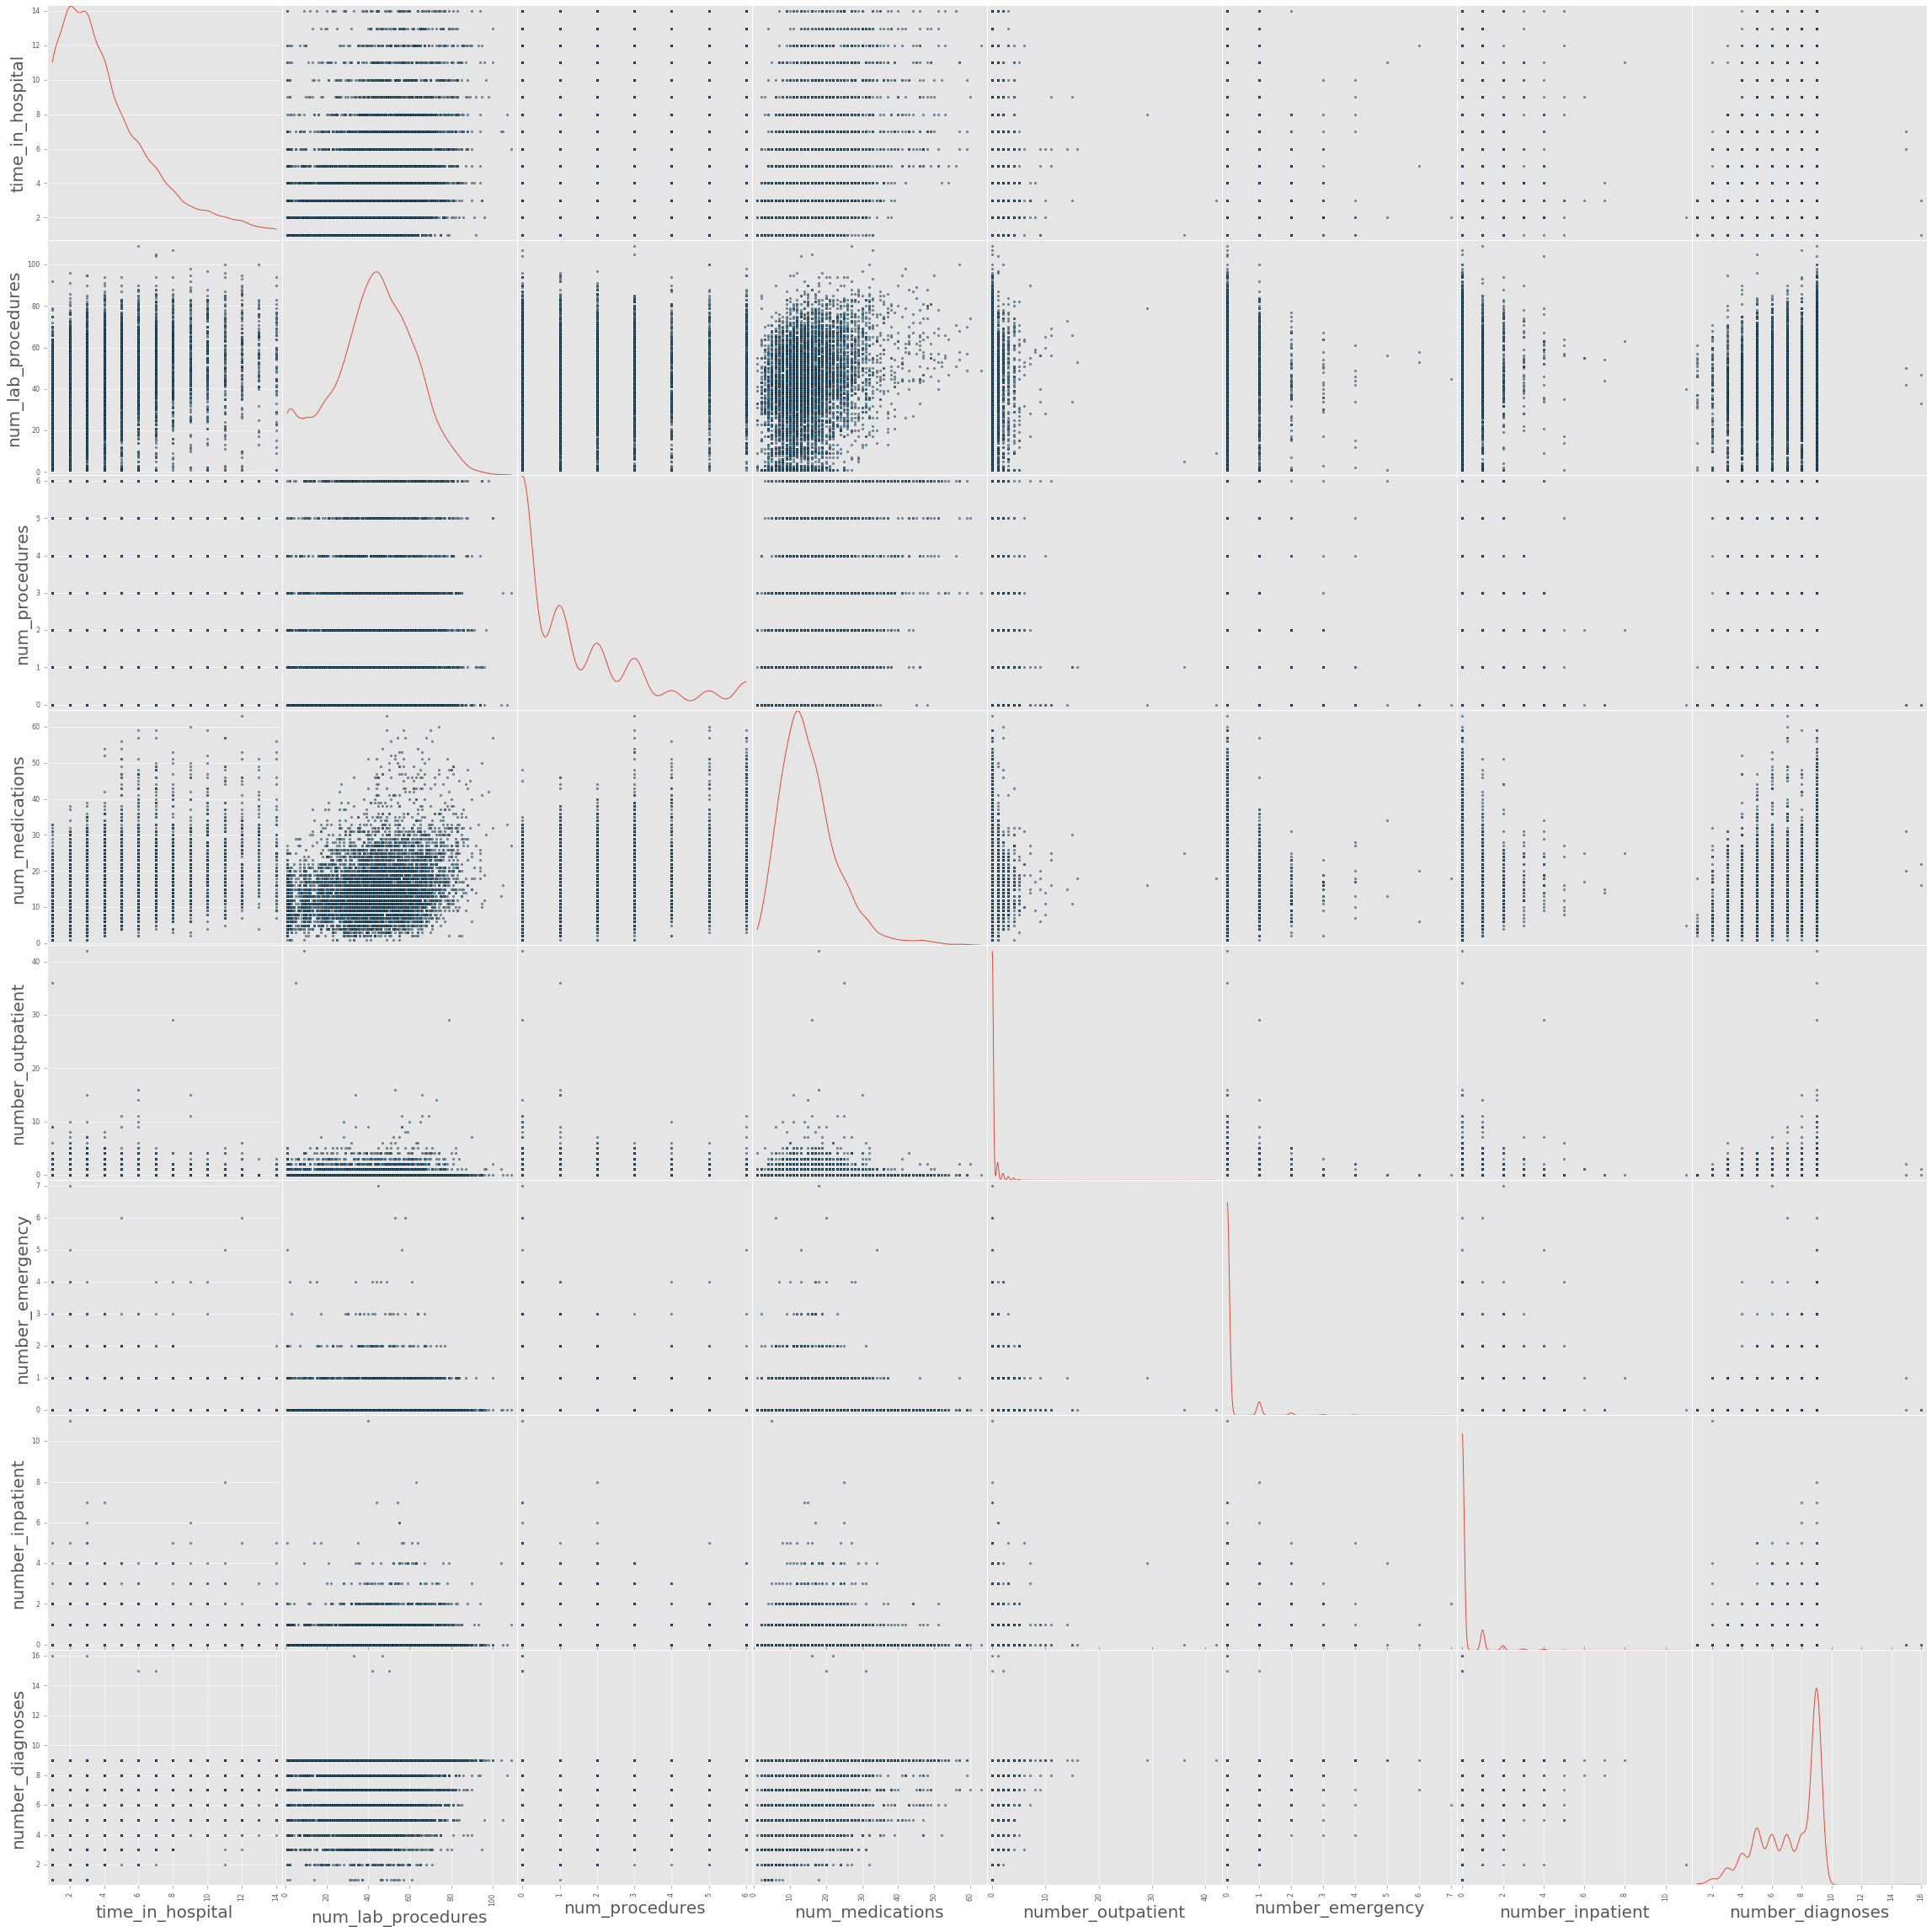

In [26]:
###############################################################
# 1. Vizualize scatter-plots matrix for the sampled dataset for Numerical attributes
###############################################################


# Scattar Matrix of each Numeric columns with each other.
dataFrameNumericPD = DataFramePlots().sampleDataFrame(diabeticCleanDF_NaN, numericFeature)
plt.rcParams['axes.labelsize'] = 20
a = scatter_matrix(dataFrameNumericPD, alpha=0.7, diagonal='kde', figsize=(40, 40), facecolor='w', edgecolor='k')

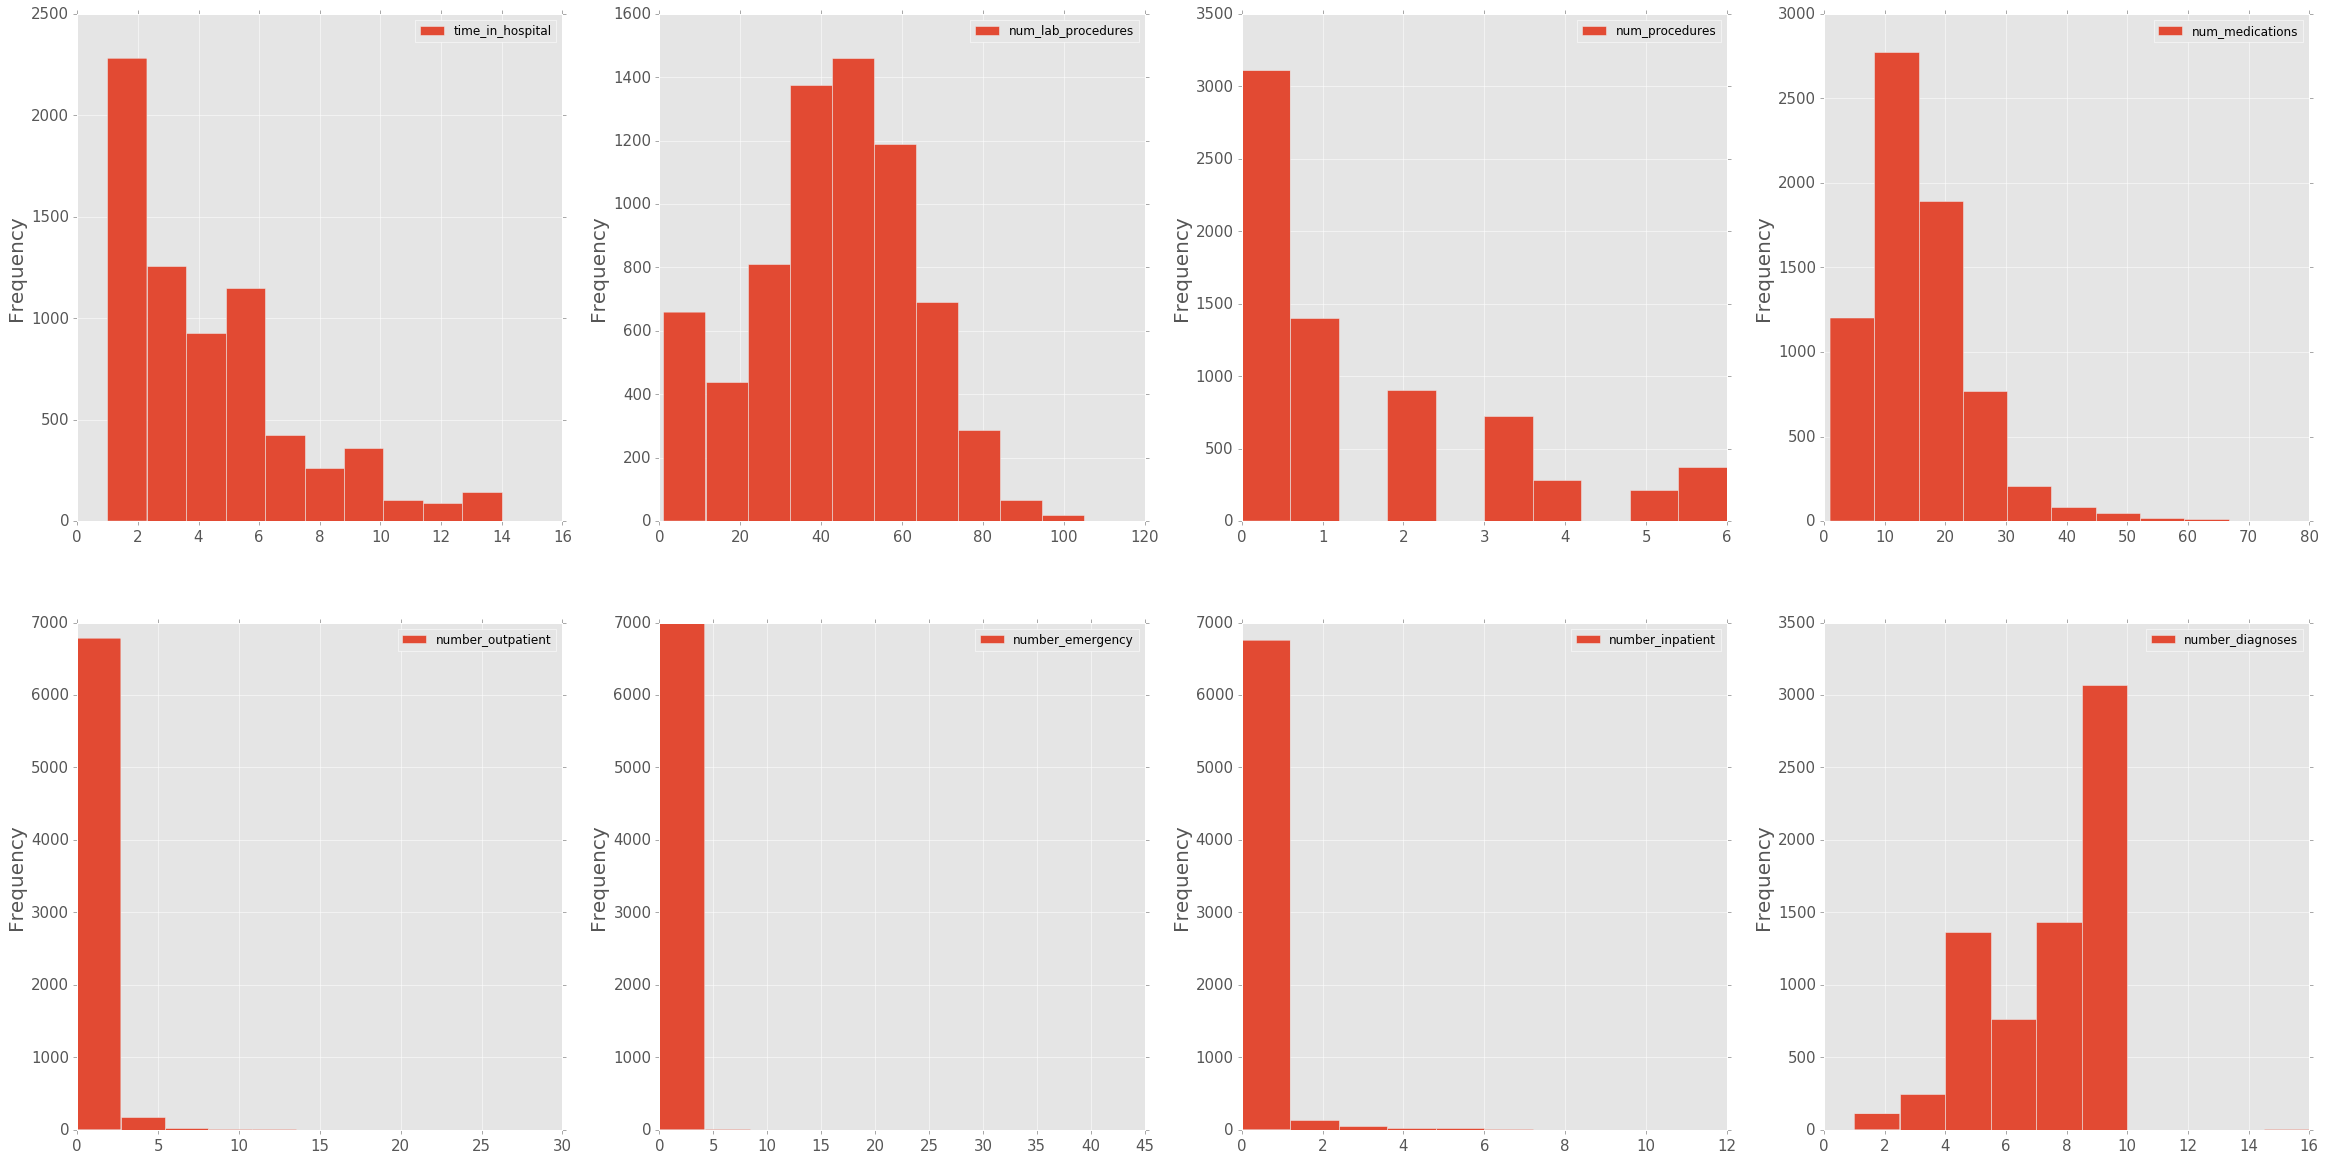

In [27]:
###############################################################
# 2. Vizualize histograms plots for the sampled dataset for Numerical attributes.
###############################################################

vizualize(dataFrameArrayNumeric, rows=2, columns=4, figsize=(40, 20), plot='hist')

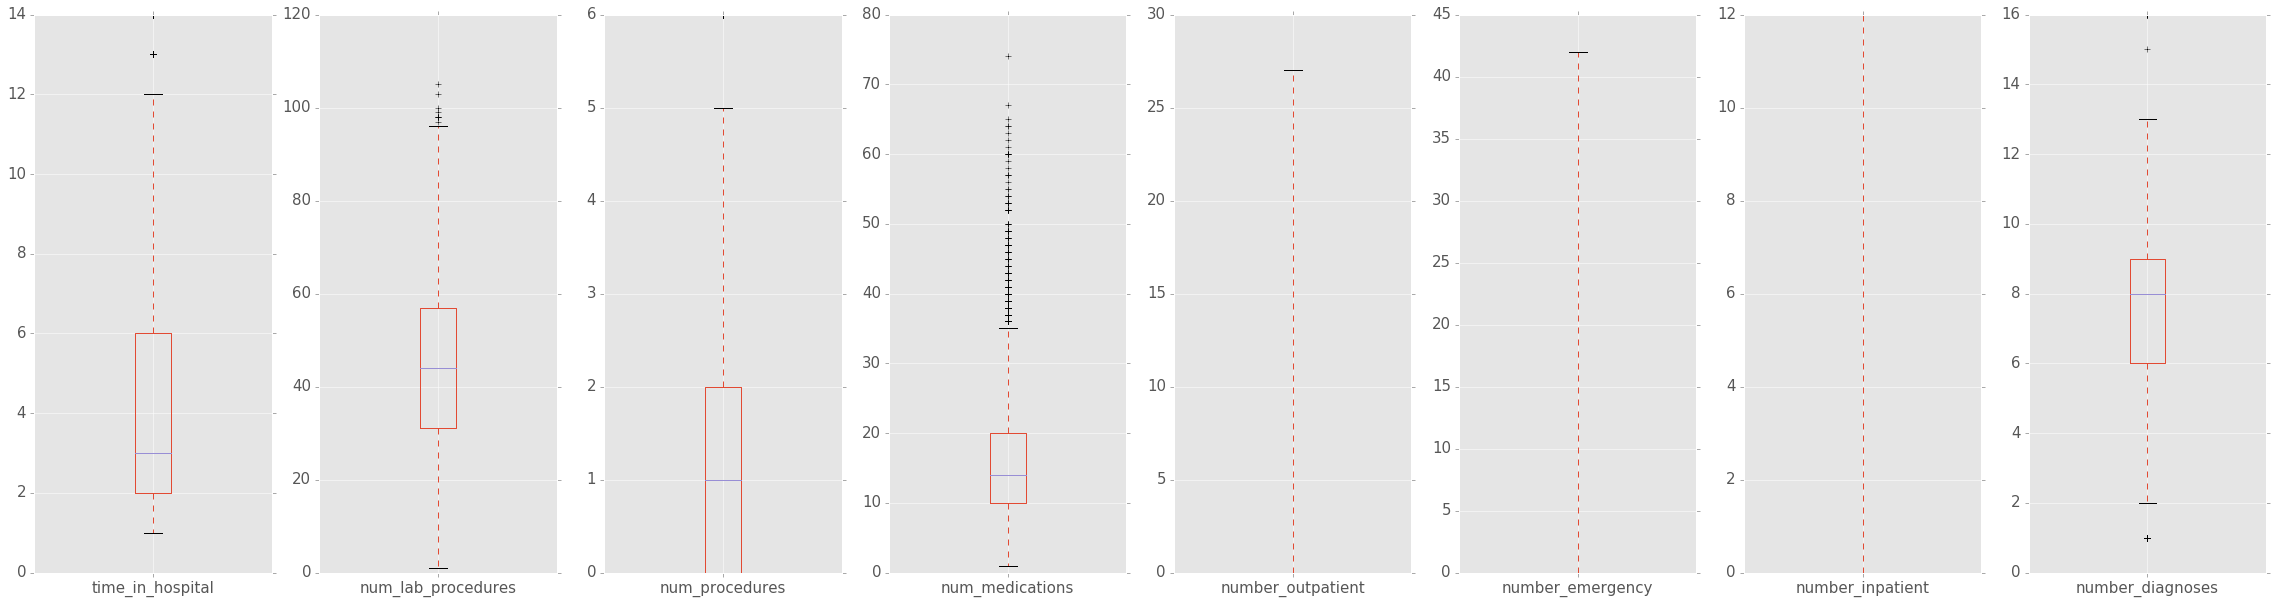

In [28]:
###############################################################
# 3. Vizualize box-plots for the sampled dataset for Numerical attributes.
###############################################################

vizualize(dataFrameArrayNumeric, rows=1, columns=8, figsize=(40, 10), plot='box')

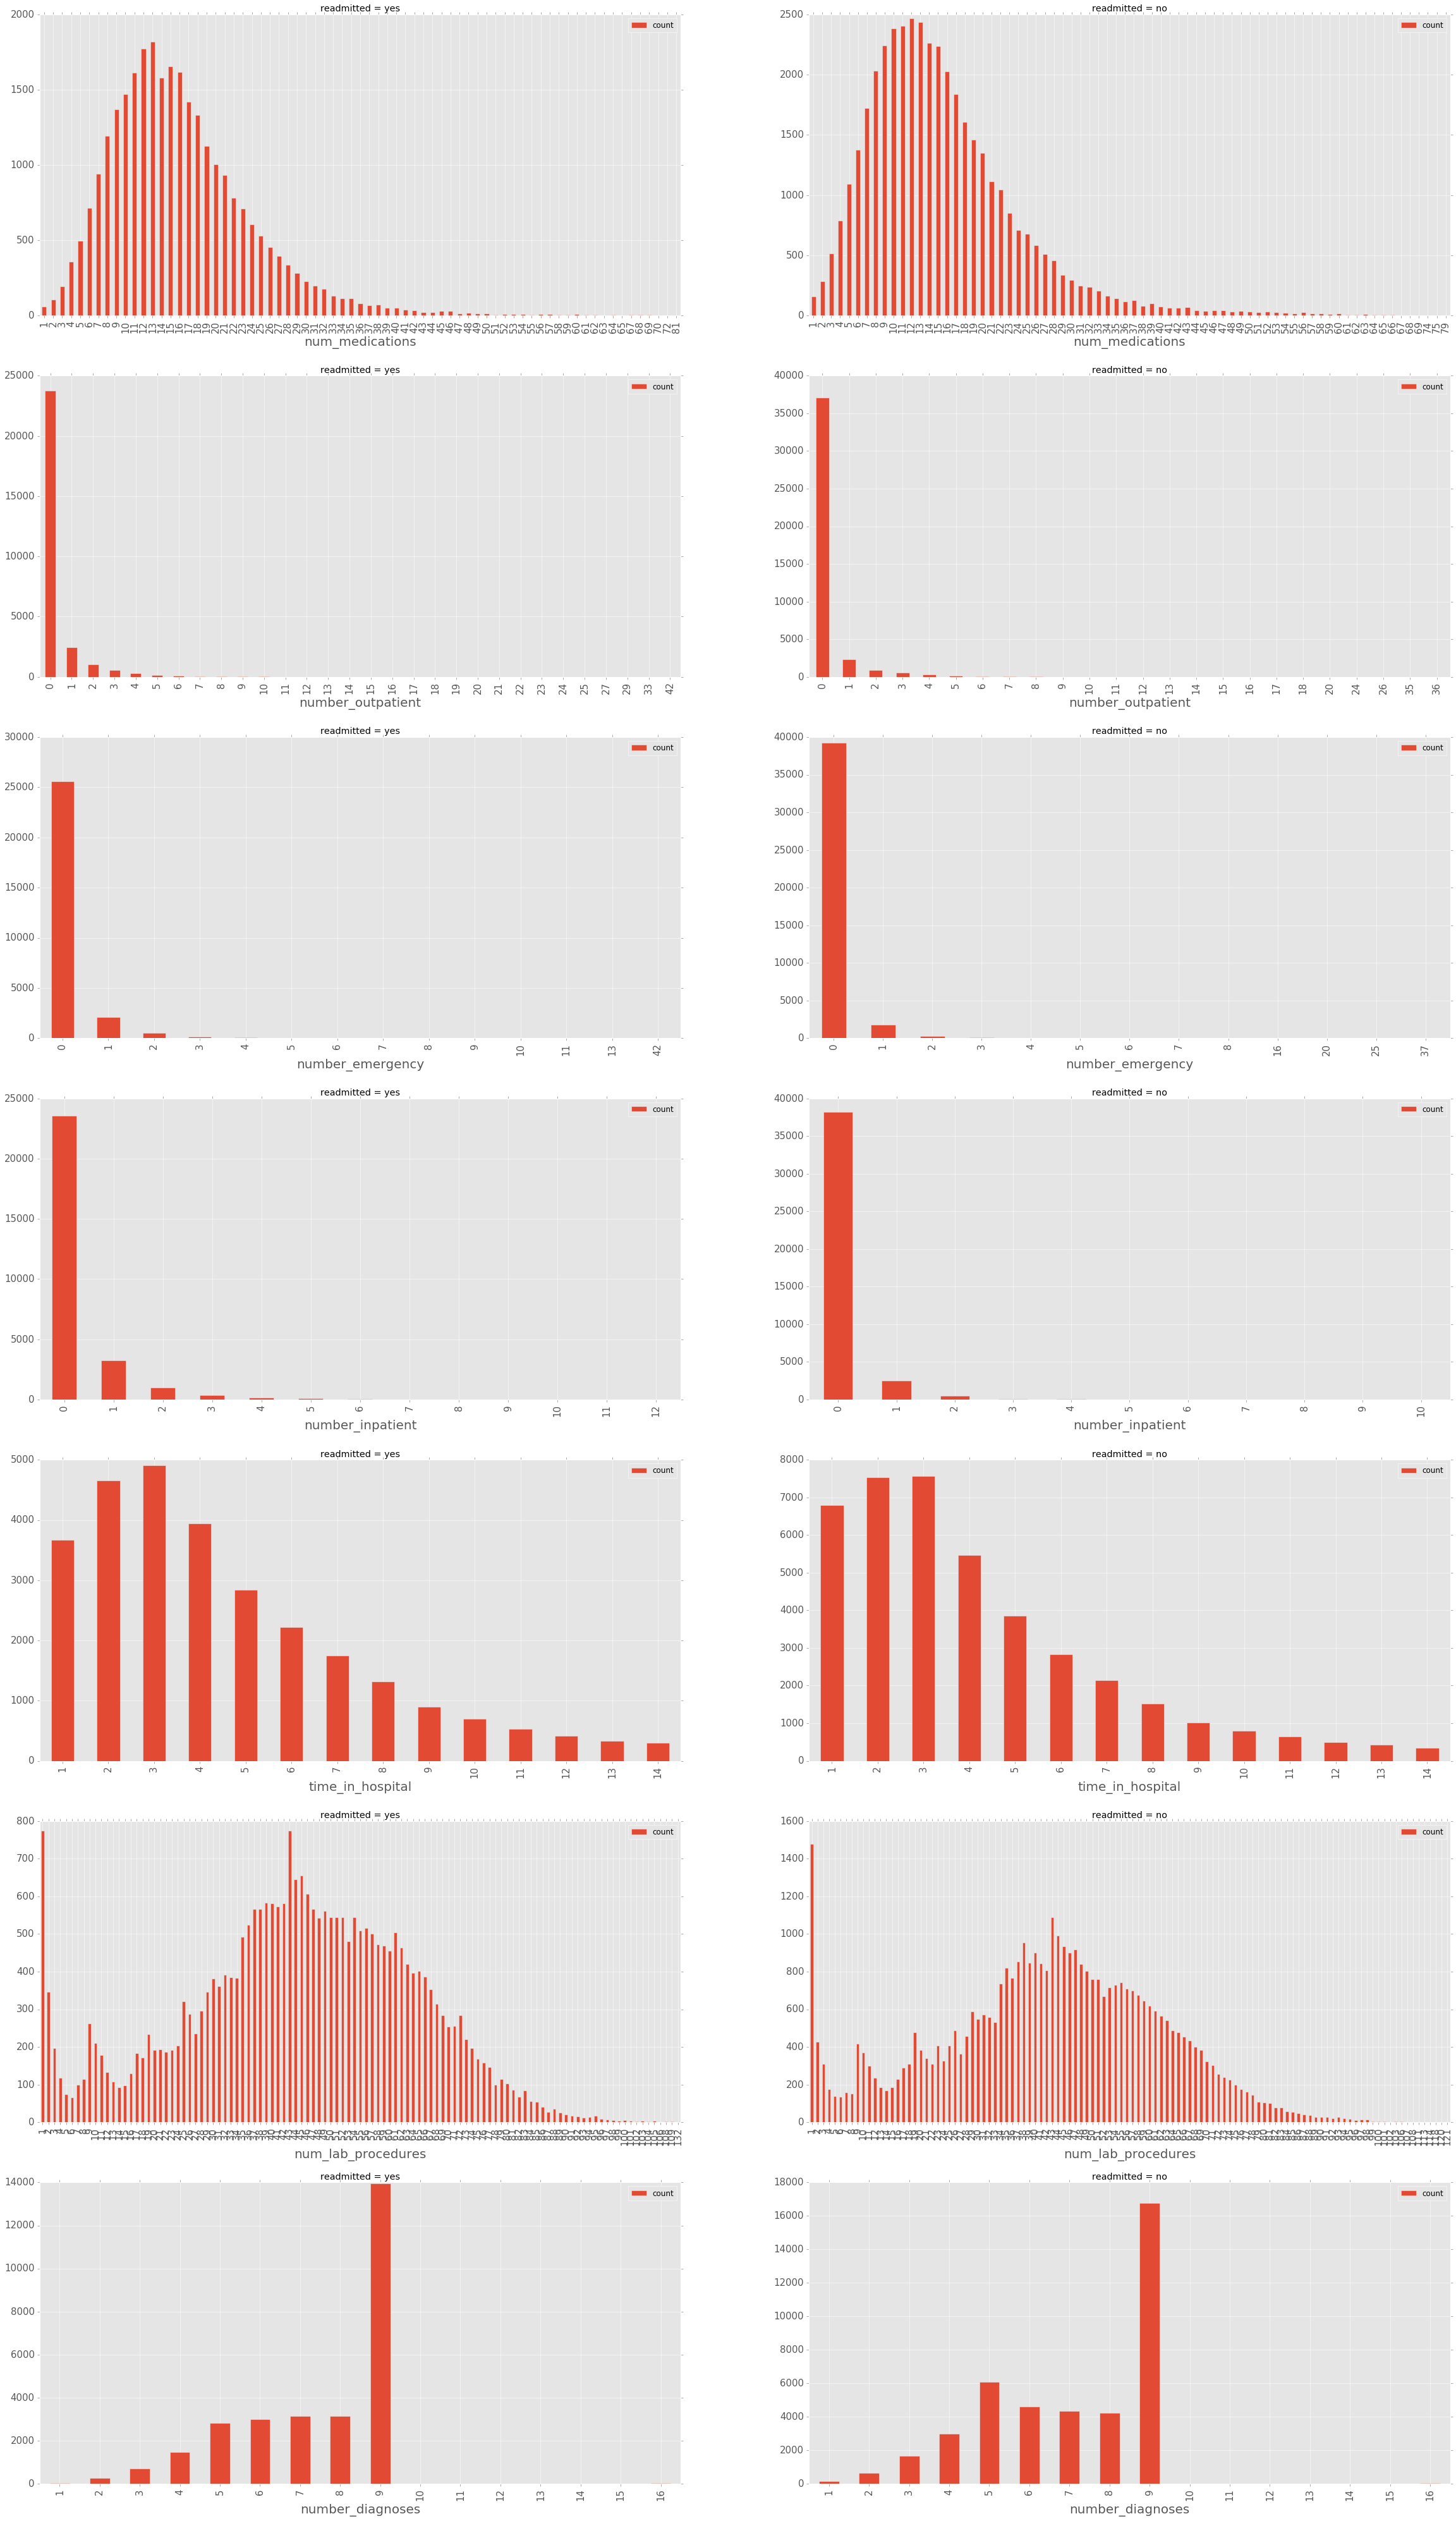

In [29]:
###############################################################
# 4. Vizualizing the distribution of the labels with some of the numerical features.
###############################################################

# Vizualizing the distribution of the class label "readmitted" with some of the numerical features. 
# Since we would do a group by we can use all the instances for the plot, not just a small sample. 
# Here we check the distribution of readmitted with num_medications, number_outpatient, number_emergency, number_inpatient

# diabeticCleanDF_NaN.groupBy('readmitted').count().show()
featureArr = ['num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient','time_in_hospital', 'num_lab_procedures', 'number_diagnoses']
labelsArr = ['yes', 'no']
dataframeArr = []
xlabels = []
ylabels = []
titles = []

for feature in featureArr:
    for labels in labelsArr: 
        df = (diabeticCleanDF_NaN.select(feature).where(func.col('readmitted')==labels).groupBy(feature).count().orderBy(feature).toPandas())
        dataframeArr.append(df)
        xlabels.append(feature)
        ylabels.append('count')
        titles.append('readmitted = ' + labels)

vizualize(dataframeArr, rows=len(featureArr), columns=len(labelsArr), figsize=(40,len(featureArr)*10), xlabels=xlabels, ylabels=ylabels, titles=titles, plot='bar')


# Stratifying Sampling and Data Analysis:

1. Load the dataset (the cleaned feature model) from the Disk.
2. Perform stratified sampling on the labels (Dependent variable) and get the test, crossValid and training data.
3. Perform Sanity check -> check if the data in the train, test and validation dataset is different.
4. Store the Train, Test and CrossValidation data into disk for re-usability.


In [8]:
###############################################################
# 1. Load the dataset (the cleaned feature model) from the Disk
###############################################################

dataFeatureModel1 = sqlContext.read.load(dataModel1, 
                      format='com.databricks.spark.csv', 
                      header='true', 
                      inferSchema='true')

print ('Total number of rows is: ', dataFeatureModel1.count())

# create a ID column to assist in preparing train, test and cross validata using stratified sampling
dataDF = dataFeatureModel1.withColumn("id", func.monotonically_increasing_id())
dataDF.cache()
dataDF.show(2)
# diabeticCleanDF.unpersist()
# diabeticCleanDF_NaN.unpersist()



69963
+---------+------+-------+-----------------+------------------------+-------------------+----------------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+-------+-------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+---------+---------+-----------+------------+-------------+--------+--------+----------+-------+-------------------+-------------------+------+-----------+----------+---+
|     race|gender|    age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1| diag_2| diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|glimepiride|glipizide|glyburide|tolbutamide|pioglitazone|rosiglitazone|acarbose|miglitol|tolazamide|insulin|glyburide_metformin

In [15]:
###############################################################
# 2. Perform stratified sampling on the labels (Dependent variable) and get the test, crossValid and training data
###############################################################


# Perform stratified sampling on the labels and get the test data
testSampleDF = dataDF.sampleBy("readmitted", fractions={'yes':0.2, 'no':0.2}, seed=67629)

print ('Number of test Data points is: ', testSampleDF.count())
print ('Proportion of group labeles in the test Dataset .. ')
testSampleDF.groupBy('readmitted').count().show()


# Fetch the record Id's already selected for the test Data set
testID = (testSampleDF
           .select('id')
           .rdd
           .map(lambda l: l[0])
           .collect())


# ------------------------------------------------------------------------------------------------------------------------


# Get the leftout dataset
leftoutSample = dataDF.filter(func.col('id').isin(testID) == False)


# ------------------------------------------------------------------------------------------------------------------------


# Perform Stratifies sampling on the left out data and extract the cross validion dataset.
validSampleDf = leftoutSample.sampleBy("readmitted", fractions={'yes':0.2, 'no':0.2}, seed=98881)

print ('Number of cross validation Data points is: ', validSampleDf.count())
print ('Proportion of group labeles in the cross validation Dataset .. ')
validSampleDF.groupBy('readmitted').count().show()

# Fetch the record Id's of the Cross Validation dataset
validID = (validSampleDf
           .select('id')
           .rdd
           .map(lambda l: l[0])
           .collect())


# ------------------------------------------------------------------------------------------------------------------------


# Get the leftout dataset as the training dataset
trainSampleDF = leftoutSample.filter(func.col('id').isin(validID) == False)

print ('Number of Training Data points is: ', trainSampleDF.count())
print ('Proportion of group labeles in the training Dataset .. ')
trainSampleDF.groupBy('readmitted').count().show()

trainID = (trainSampleDF
           .select('id')
           .rdd
           .map(lambda l: l[0])
           .collect())


Number of test Data points is:  14029
Proportion of group labeles in the test Dataset .. 
+----------+-----+
|readmitted|count|
+----------+-----+
|        no| 8230|
|       yes| 5799|
+----------+-----+

Number of cross validation Data points is:  11259
Proportion of group labeles in the test Dataset .. 
+----------+-----+
|readmitted|count|
+----------+-----+
|        no| 6679|
|       yes| 4580|
+----------+-----+

Number of Training Data points is:  44675
Proportion of group labeles in the test Dataset .. 
+----------+-----+
|readmitted|count|
+----------+-----+
|        no|26559|
|       yes|18116|
+----------+-----+



In [20]:
###############################################################
# 3. Perform Sanity check -> check if the data in the train, test and validation dataset is different.
###############################################################

# A simple python for loop to check if data repeatation in Trainig, Test and Cross-Validation dataset.
print ([1 for tid in trainID if tid in validID], [1 for tid in trainID if tid in testID], [1 for vid in validID if vid in testID])

[] [] []


In [24]:
###############################################################
# 4. Store the Train, Test and CrossValidation data into disk for re-usability.
###############################################################

trainSampleDF.write.option("header", "true").csv(trainSampleModel1)
testSampleDF.write.option("header", "true").csv(testSampleModel1)
validSampleDf.write.option("header", "true").csv(validSampleModel1)

# Data Pipeline 1 - Logistic Regression (Ridge, Lasso, EN)

1. Load the train, test and crossValid dataset from the disk.
2. Remove the ID column from each of the dataset as we wont be using it in model
3. Perform LASO Regression.

In [4]:
###############################################################
# 1. Load the train, test and crossValid dataset from the disk.
# 2. Remove the ID column from each of the dataset as we wont be using it in model
###############################################################

trainDFm1 = sqlContext.read.load(trainSampleModel1, 
                      format='com.databricks.spark.csv', 
                      header='true', 
                      inferSchema='true')

validDFm1 = sqlContext.read.load(validSampleModel1, 
                      format='com.databricks.spark.csv', 
                      header='true', 
                      inferSchema='true')

trainDFm1 = trainDFm1.drop(*['id'])
validDFm1 = validDFm1.drop(*['id'])

print (trainDFm1.count())
print (validDFm1.count())

44675
11259


# Running an Example : Logistic Regression (Rough)

In [2]:
trackfilepath = "/Users/sam/All-Program/App-DataSet/Spark-Operations/adult.txt"

In [3]:
dataset = sqlContext.read.load(trackfilepath, 
                      format='com.databricks.spark.csv', 
                      header='true', 
                      inferSchema='true')

In [4]:
display(dataset)

DataFrame[age: int, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string]

In [5]:
cols = dataset.columns
cols

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country',
 'income']

In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
  # Category Indexing with StringIndexer
  stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index")
  # Use OneHotEncoder to convert categorical variables into binary SparseVectors
  encoder = OneHotEncoder(inputCol=categoricalCol+"Index", outputCol=categoricalCol+"OneHot")
  # Add stages.  These are not run here, but will run all at once later on.
  stages += [stringIndexer, encoder]
    
# Stages creates the pipeline

In [7]:
# one-hot encoder label column
label_stringIdx = StringIndexer(inputCol = "income", outputCol = "label")
stages += [label_stringIdx]

In [8]:
stages

[StringIndexer_4c1fbcc300866cfc73b0,
 OneHotEncoder_4184b95f1d9e216067d0,
 StringIndexer_457fbb2829307df14151,
 OneHotEncoder_4e3eb927e6b9a426cb76,
 StringIndexer_46f0b466bc23f9e58c5e,
 OneHotEncoder_4c9eaf17c385f3287d94,
 StringIndexer_49ceaabf7db0d141be98,
 OneHotEncoder_44a99013a4093d414020,
 StringIndexer_4d0c9bf8c10f634b2eb4,
 OneHotEncoder_41c398df1c8bdcc5700f,
 StringIndexer_474fa4dd3a84acf1466d,
 OneHotEncoder_4ca69cedae2ac33d20bd,
 StringIndexer_4debb83cd44b9e9fbb3a,
 OneHotEncoder_440799bfcf003b246ec3,
 StringIndexer_4b8d89c711ecd0dc5da5,
 OneHotEncoder_4bc3a13a25f6314b01fa,
 StringIndexer_40c78f015406c2c93fb4]

In [9]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
# assemblerInputs = map(lambda c: c + "classVec", categoricalColumns) + numericCols
assemblerInputs = [i+"OneHot" for i in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [10]:
assemblerInputs

['workclassOneHot',
 'educationOneHot',
 'marital_statusOneHot',
 'occupationOneHot',
 'relationshipOneHot',
 'raceOneHot',
 'sexOneHot',
 'native_countryOneHot',
 'age',
 'fnlwgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week']

In [11]:
pipeline = Pipeline(stages=stages)
# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
pipelineModel = pipeline.fit(dataset)
dataset = pipelineModel.transform(dataset)

# Keep relevant columns
selectedcols = ["label", "features"] + cols
dataset = dataset.select(selectedcols)
display(dataset)

DataFrame[label: double, features: vector, age: int, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string]

In [12]:
dataset.select('label','features').show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(100,[4,10,24,32,...|
|  0.0|(100,[1,10,23,31,...|
|  0.0|(100,[0,8,25,38,4...|
|  0.0|(100,[0,13,23,38,...|
|  0.0|(100,[0,10,23,29,...|
|  0.0|(100,[0,11,23,31,...|
|  0.0|(100,[0,18,28,34,...|
|  1.0|(100,[1,8,23,31,4...|
|  1.0|(100,[0,11,24,29,...|
|  1.0|(100,[0,10,23,31,...|
|  1.0|(100,[0,9,23,31,4...|
|  1.0|(100,[4,10,23,29,...|
|  0.0|(100,[0,10,24,32,...|
|  0.0|(100,[0,14,24,33,...|
|  1.0|(100,[0,12,23,30,...|
|  0.0|(100,[0,16,23,37,...|
|  0.0|(100,[1,8,24,39,4...|
|  0.0|(100,[0,8,24,35,4...|
|  0.0|(100,[0,13,23,33,...|
|  1.0|(100,[1,11,25,31,...|
+-----+--------------------+
only showing top 20 rows



In [13]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print (trainingData.count())
print (testData.count())

22838
9723


In [14]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
lrModel = lr.fit(trainingData)

In [15]:
predictions = lrModel.transform(testData)
predictions.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [16]:
selected = predictions.select("label", "prediction", "probability", "age", "occupation")
selected.show()

+-----+----------+--------------------+---+---------------+
|label|prediction|         probability|age|     occupation|
+-----+----------+--------------------+---+---------------+
|  0.0|       0.0|[0.69234532795194...| 26| Prof-specialty|
|  0.0|       0.0|[0.62115531452964...| 30| Prof-specialty|
|  0.0|       0.0|[0.65845294177529...| 31| Prof-specialty|
|  0.0|       0.0|[0.65826620022842...| 32| Prof-specialty|
|  0.0|       0.0|[0.61503423805722...| 39| Prof-specialty|
|  0.0|       0.0|[0.53986082134083...| 47| Prof-specialty|
|  0.0|       0.0|[0.60044732389245...| 50| Prof-specialty|
|  0.0|       0.0|[0.58986249819721...| 51| Prof-specialty|
|  0.0|       0.0|[0.58241874548816...| 60| Prof-specialty|
|  0.0|       0.0|[0.59201535021361...| 61| Prof-specialty|
|  0.0|       0.0|[0.83734366646202...| 26| Prof-specialty|
|  0.0|       0.0|[0.98988682399118...| 20| Prof-specialty|
|  0.0|       1.0|[0.41522833169039...| 35| Prof-specialty|
|  0.0|       0.0|[0.72017833060569...| 

In [17]:
selected.crosstab('label', 'prediction').show()   # Prediction confusion matrix

+----------------+----+----+
|label_prediction| 0.0| 1.0|
+----------------+----+----+
|             1.0| 964|1411|
|             0.0|6847| 501|
+----------------+----+----+



In [18]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)
evaluator.getMetricName()
evaluator

'areaUnderROC'

BinaryClassificationEvaluator_44859cff6d27e0f905b5

In [137]:
print (lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
maxIter: max number of iterations (>= 0). (default: 100, current: 10)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
rawPredictionCol: raw p

In [35]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
# lr.elasticNetParam, [0.0, 0.5, 1.0], here (0.0=ridge, 0.5=elasticnet and 1.0=lasso)
# lr.regParam, [0.01, 0.5, 2.0]  these are the values of lambda
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.5, 2.0, 2.5, 3])
             .addGrid(lr.elasticNetParam, [1.0])
             .addGrid(lr.maxIter, [100])
             .build())

In [36]:
# Will take more time because we use more parameters here
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)   # creates 5 fold cross validation
cvModel = cv.fit(trainingData)

In [37]:
print ("modelCoefficient = ", cvModel.bestModel.coefficients)
print ('')
print ('Model Intercept: ', cvModel.bestModel.intercept)
print ('')
print ('Best Model Parameters: ', cvModel.bestModel.getParam)
print ('')
print ('Best Model Parameters: ', cvModel.bestModel.summary)
print ('')
# print ('Best Model Parameters: ', cvModel.uid)

modelCoefficient =  [-0.298226464091,-0.769234164615,-0.364074913872,-0.695720687422,-0.531081966614,-0.0856842226495,0.23085796856,-1.8635736345,-0.685503192397,-0.277321571566,0.433457453614,0.839827849343,-0.124431932022,-1.3099796026,-0.0636393648886,-1.47053568453,-1.94002974603,1.25834739211,-1.72035633073,-0.926773124381,1.4654554331,-1.79713868345,-1.49843901137,0.194134758528,-1.64550528299,-1.22066636924,-1.1529339299,-0.927968494393,-1.09028914908,0.102419465147,-0.331301125855,0.352492777206,-0.330458576031,-0.0920155703887,-1.18338047896,-0.721799695112,-0.714863500413,-0.529770435384,-1.17194906187,-1.30117672204,0.214849842798,0.0660757548601,-2.10404506122,0.128162433187,-0.100556442516,-1.0652289626,-0.196791527111,1.39408010363,-0.219949076995,-0.509994359375,-0.344150004144,-0.921062280156,0.93788850628,-0.275221780798,-1.30718269882,-0.610553267786,0.0,0.0,-0.0766594789474,-0.852691674629,-0.920462220955,-0.627641272822,0.0,-0.197235452852,-0.298916238169,-1.4765189

In [38]:
predictions = cvModel.transform(testData)
evaluator.evaluate(predictions)
selected = predictions.select("label", "prediction", "probability", "age", "occupation")

In [39]:
selected.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 7348|
|  1.0| 2375|
+-----+-----+



In [40]:
selected.crosstab('label', 'prediction').show()

+----------------+----+----+
|label_prediction| 0.0| 1.0|
+----------------+----+----+
|             1.0| 956|1419|
|             0.0|6876| 472|
+----------------+----+----+

